### Trabajo Final Master Ciencia de Datos y Business Analytics
## Reporte Laboratorio Seco - Modelo de Regresión Lineal
Septiembre 9, 2023

## Introducción
El siguiente cuaderno de laboratorio es el registro de la aplicación de un modelo de regresión lineal con el objetivo de encontrar el pronóstico adecuado a la data de POS de Sportline Colombia. 

## Lectura de Datos, Adecuación de las Variables, Feature Engineering
Para el entrenamiento de los datos, es importante leerlos del archivo de juegos de datos POS del datamart. En este caso en particular, se leen los datos extraidos para el _TFM_ correspondientes a las ventas de Sportline America Colombia del 1 de enero del 2018 al 30 de julio del 2023. 

In [2]:
# Importar y leer archivo como DF Pandas
# Los archivos se leen de los formatos por año ya limpios

import pandas as pd
csv_file_path = '/Users/ameilij/Documents/Master Data Science/MDS/tfm/data_clean/master_POS_SLA_COL_diario.csv'
encoding = 'latin1'
dfPOS = pd.read_csv(csv_file_path, encoding=encoding)
dfPOS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9069 entries, 0 to 9068
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CODIGO_MARCA  9069 non-null   float64
 1   FECHA         9069 non-null   object 
 2   CANTIDAD      9069 non-null   int64  
 3   WEEK_OF_YEAR  9069 non-null   object 
 4   YEAR          9069 non-null   int64  
 5   MONTH         9069 non-null   object 
 6   XMAS          9069 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 496.1+ KB


A pesar que los datos están preparados para el análisis, al archivarlos como CSV pierden sus propiedades intrínsecas. Debemos asegurarnos que los tipos de fecha se interpretan correctamente por _Pandas_. Adicionalmente recurriremos al uso de __feature engineering__ para agregar en el juego de datos algunas variables que salieron a relucir en el análisis EDA como interesantes para optimizar la función de perdida en la regresión multivariable.

* La variable `YEAR` como regresor que interpreta el año
* La variable `WEEK_LAST_TWO_DIGITS` como un post-proceso de la variable que extrae la semana correspondiente al año. Hacemos esto porque hemos visto cierta inestabilidad en el código de Pandas para sistemas Mac corriendo en procesadores M1/M2.
* La variable `XMAS` como regresor que interpreta el hecho que en diciembre las ventas siempre se disparan muy por encima del promedio normal. 
* La variable `COVID` para aislar el efecto de valores bajos en venta durante las fechas de cierre que implementó el gobierno de Colombia entre marzo y agosto del 2020. 

El juego de entrenamiento finalmente filtra los datos para la marca `456`, que es la categoría de zapatillas. 

In [3]:
# Preparar el archivo para entrenamiento
dfPOS['FECHA'] = pd.to_datetime(dfPOS['FECHA'], format= '%Y-%m-%d')
dfPOS['WEEK_LAST_TWO_DIGITS'] = dfPOS['WEEK_OF_YEAR'].str[-2:]
dfPOS['WEEK_LAST_TWO_DIGITS'] = pd.to_numeric(dfPOS['WEEK_LAST_TWO_DIGITS'])


# Crear YEAR y MONTH extraidas de la columna FECHA
dfPOS['YEAR'] = dfPOS['FECHA'].dt.year
dfPOS['MONTH'] = dfPOS['FECHA'].dt.month

# Crear la variable XMAS para saber que es mes de ventas de navidad =)
dfPOS['XMAS'] = dfPOS['MONTH'].apply(lambda x: 1 if x == 1 else 0)

# Crear la variable COVID para saber que en ese momento estaba el país en cierre parcial
# Define the date range for COVID-19 lockdowns
start_date = pd.to_datetime('2020-03-01')
end_date = pd.to_datetime('2020-08-01')
dfPOS['COVID'] = dfPOS['FECHA'].apply(lambda date: 1 if pd.to_datetime('2020-03-01') <= date 
                                    < pd.to_datetime('2020-08-01') else 0)

data_train = dfPOS[dfPOS['CODIGO_MARCA'] == 456]

Antes de comenzar el entrenamiento, revisemos una vez más la topología de la data para asegurarnos que tiene el valor esperado. 

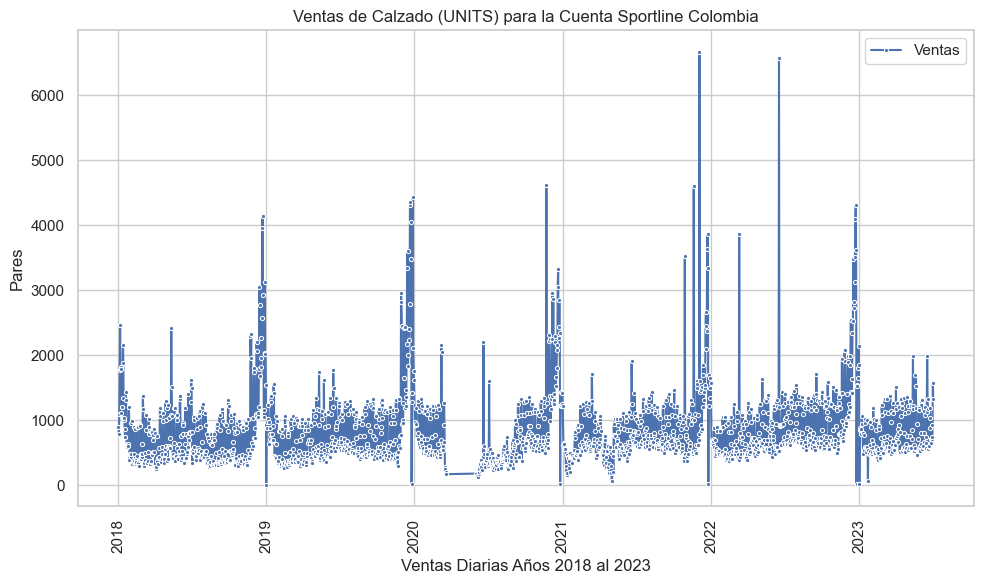

In [5]:
# Revisar la topologia de la serie de tiempos
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar la data por 'CODIGO_MARCA', y la semana del año
data_temp = data_train[['FECHA', 'CANTIDAD']].sort_values(by='FECHA', ascending=True)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='FECHA', y='CANTIDAD', data=data_temp, marker='.', label='Ventas')
plt.title('Ventas de Calzado (UNITS) para la Cuenta Sportline Colombia')
plt.xlabel('Ventas Diarias Años 2018 al 2023')
plt.ylabel('Pares')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()  # Add a legend to label the line

plt.show()

## Entrenamiento de Datos
Para el entrenamiento de datos, se utiliza la librería `sklearn`. __Scikit-learn__, a menudo abreviado como sklearn, es una biblioteca de Python ampliamente utilizada para tareas de ciencia de datos y aprendizaje automático. Proporciona herramientas simples y eficientes para el análisis y modelado de datos, incluidos varios algoritmos de clasificación, regresión, agrupación, reducción de dimensionalidad, selección de modelos y más. Scikit-learn se basa en otras bibliotecas populares de Python como __NumPy__ y __SciPy__ y está diseñado para ser fácil de usar e integrar en flujos de trabajo de ciencia de datos. Es una herramienta poderosa tanto para principiantes como para científicos de datos experimentados cuando trabajan en proyectos de aprendizaje automático en Python.

In [6]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Por las dudas, convertir 'FECHA' a un formato numérico, para facilitar utilizarlo como regresor en sklearn
start_date = min(data_train['FECHA'])
data_train['DAYS_SINCE_START'] = (data_train['FECHA'] - start_date).dt.days

X = data_train[['WEEK_LAST_TWO_DIGITS', 'MONTH', 'YEAR', 'XMAS', 'COVID']]
y = data_train['CANTIDAD']

# Construir juegos de entrenamiento y test, dividiendo 80% de los datos para entrenamiento y 
# 20% para validación. Se utiliza la semilla random_state=42 para seed (no es culpa del alumno
# que los creadores de sklearn leyeron The Hitchhiker's Guide to the Galaxy)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train).fit()
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

/var/folders/9c/f5lf7vz91zs8mwbnjbtxzjgw0000gn/T/ipykernel_13922/569978994.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['DAYS_SINCE_START'] = (data_train['FECHA'] - start_date).dt.days


## Evaluación del Modelo 
Evaluamos el poder de predicción del modelo comparando los valores reales del juego de test contra los valores de predicción. 

In [7]:
# Calcular Mean Squared Error (MSE) y R-squared (R2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared (R2): {r2}")

print(model.summary())

Mean Squared Error: 243568.11985688534
R-squared (R2): 0.1804576674091366
                            OLS Regression Results                            
Dep. Variable:               CANTIDAD   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     53.36
Date:                Sun, 01 Oct 2023   Prob (F-statistic):           3.47e-51
Time:                        18:08:42   Log-Likelihood:                -11938.
No. Observations:                1543   AIC:                         2.389e+04
Df Residuals:                    1537   BIC:                         2.392e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

Basado en el reporte resumen y la evaluación de las métricas, no es inapropiado decir que el modelo no tiene un desempeño bueno para predecir los valores futuros de las ventas de zapatillas. Veamos una por una las observaciones críticas.

1. **Error cuadrático medio (MSE)**: el valor de MSE es bastante alto (243568,12). Un MSE alto indica que las predicciones del modelo son significativamente diferentes de los valores reales. En otras palabras, las predicciones del modelo tienen una gran variación de errores.

2. **R cuadrado (R2)**: El valor de R cuadrado es relativamente bajo (0,1805). R cuadrado mide la proporción de la varianza de la variable dependiente (CANTIDAD) que es predecible a partir de las variables independientes. Un R cuadrado bajo sugiere que el modelo explica solo una pequeña porción de la varianza en los datos, lo que indica un ajuste deficiente del modelo.

3. **R cuadrado ajustado**: También es bajo (0,145), lo que sugiere que agregar más variables independientes al modelo no mejoró significativamente su ajuste. Esto es un poco decepcionante, ya que esperábamos que las variables agregadas de XMAS y COVID ayudaran a aislar - o mejorar - la interpretación de los efectos de pandemia y aumento de las ventas en Navidad. 

4. **Estadística F**: La estadística F mide la significancia general del modelo de regresión. Un estadístico F alto indica que el modelo en su conjunto es significativo. En este caso, el estadístico F (53,36) es relativamente alto, lo que sugiere que el modelo tiene cierto poder explicativo, pero esto es inconsistente con el bajo valor de R cuadrado.

5. **AIC y BIC**: Son criterios de información utilizados para la selección del modelo. Se prefieren valores más bajos. Tanto los valores AIC como BIC son relativamente altos, lo que indica que el modelo puede no ser el que mejor se ajusta a los datos.

6. **Número de observaciones y grado de libertad del modelo**: Es importante considerar el número de observaciones (1543) en relación con el número de características o parámetros en el modelo (Modelo Df: 5). Tener muy pocas observaciones para el número de parámetros puede provocar un sobreajuste.

En resumen, el modelo proporcionado no está funcionando bien. Visualmente podemos revisar el comportamiento del modelo versus los valores reales con una gráfica donde se comparen ambos:

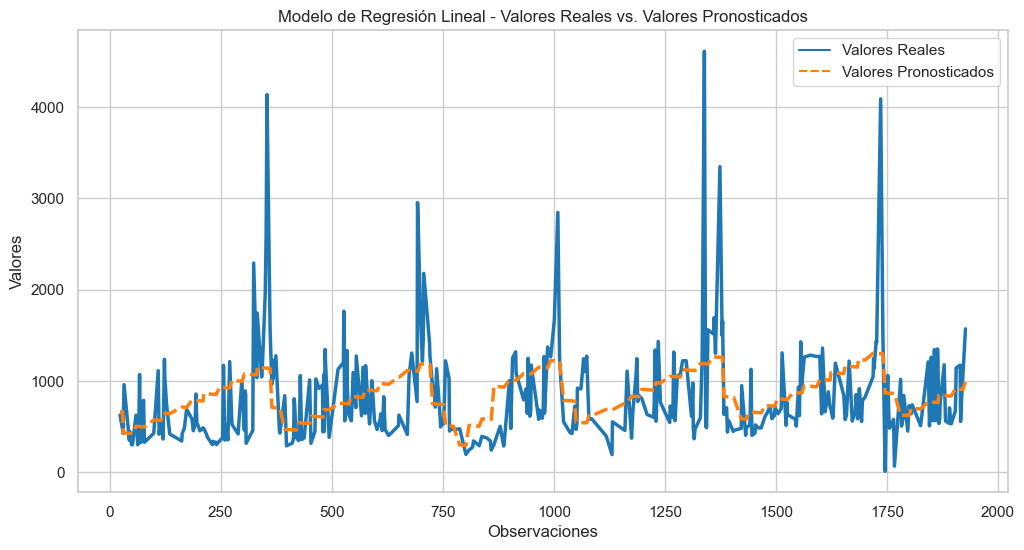

In [8]:
comparison_df = pd.DataFrame({'Valores Reales': y_test, 'Valores Pronosticados': y_pred})
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, palette="tab10", linewidth=2.5)

plt.xlabel("Observaciones")
plt.ylabel("Valores")
plt.title("Modelo de Regresión Lineal - Valores Reales vs. Valores Pronosticados")
plt.show()

## Análisis de los Resultados
El modelo de regresión lineal no es óptimo. Sin embargo, el hecho que tenemos un valor F alto y un valor R2 bajo significa que nuestro modelo tiene valor de predicción estadístico, y pudieramos revisar algunos planteamientos que mejoraran el poder de predicción. Los más interesantes son:

1. __Uso de un modelo polinómico:__ es evidente en la gráfica que compara valores reales versus nuestra predicción que nuestra función no interpreta bien los picos de temporada alta, e inclusive tiene una topología de _onda cuadrada_. Pudieramos utilizar un modelo de regresión polinómico para mejorar la interpretación de los datos. 

2. __Escalado y normalización de funciones:__ no nos hemos asegurado de que las funciones estén escaladas y normalizadas correctamente. Algunos modelos de regresión, especialmente aquellos basados en el descenso de gradientes, se benefician de tener características estandarizadas.

3. __Regularización__: no hemos utilizado para nada regularización y escalado de los datos. Aplicar regularización L1 (Lasso) o L2 (Ridge) pudiera mejorar mucho nuestro modelo. 

En pro de mejorar el modelo, probaremos hacer cambio al entrenamiento para introducir estas tres variaciones, buscando cual es la que optimiza nuestro poder de predicción.

## Variación 1: Regularización L1 y L2
Se efectuaron pequeños cambios al código para evaluar los resultados con la implementación de regularización.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso  
from sklearn.linear_model import Ridge  

# Escalar datos para la regularización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Probar modelos de entrenamiento con L1 y L2 en paralelo
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train_scaled, y_train)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

lasso_y_pred = lasso_model.predict(X_test_scaled)
ridge_y_pred = ridge_model.predict(X_test_scaled)

# Evaluar los modelos
lasso_mse = mean_squared_error(y_test, lasso_y_pred)
ridge_mse = mean_squared_error(y_test, ridge_y_pred)

lasso_r_squared = r2_score(y_test, lasso_y_pred)
ridge_r_squared = r2_score(y_test, ridge_y_pred)

print(f"Lasso MSE: {lasso_mse}")
print(f"Lasso R2: {lasso_r_squared}")

print(f"Ridge MSE: {ridge_mse}")
print(f"Ridge R2: {ridge_r_squared}")


Lasso MSE: 243382.6820989607
Lasso R2: 0.18108161644142062
Ridge MSE: 243484.3941311583
Ridge R2: 0.18073938234211095


Ninguno de los dos modelos mejoró los resultados, ya que si los comparamos, son básicamente los mismos.

|                   |         MSE        |          R2         |
|-------------------|:------------------:|:-------------------:|
| Regresión Lineal  | 243568.11985688534 | 0.1804576674091366  |
| Regularización L1 | 243382.6820989607  | 0.18108161644142062 |
| Regularización L2 | 243484.3941311583  | 0.18073938234211095 |


## Variación 2: Modelo de Regresión Polinómico
Habíamos comentado que la función de predicción se veía - antes nuestros ojos - muy cuadrada. Quizás el uso de un modelo polinómico mejore el poder de predicción al interpretar mejor la función que se ajusta al movimiento de la serie de tiempo. 

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Crear el modelo polinómico con grado 4
poly_degree = 4  
poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)

# Evaluación
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2: {r_squared}")


Mean Squared Error: 181688.80660193524
R2: 0.38866519782764974


El alumno varió el número de grado del polinomio de 2 a 12, con el mejor resultado de R2 siendo un polinomio de grado 4. La variación introducida en el modelo polinómico mejoró un poco el poder de predicción del modelo. Revisemos la gráfica donde comparamos los valores reales del juego de test con los valores pronósticados: 

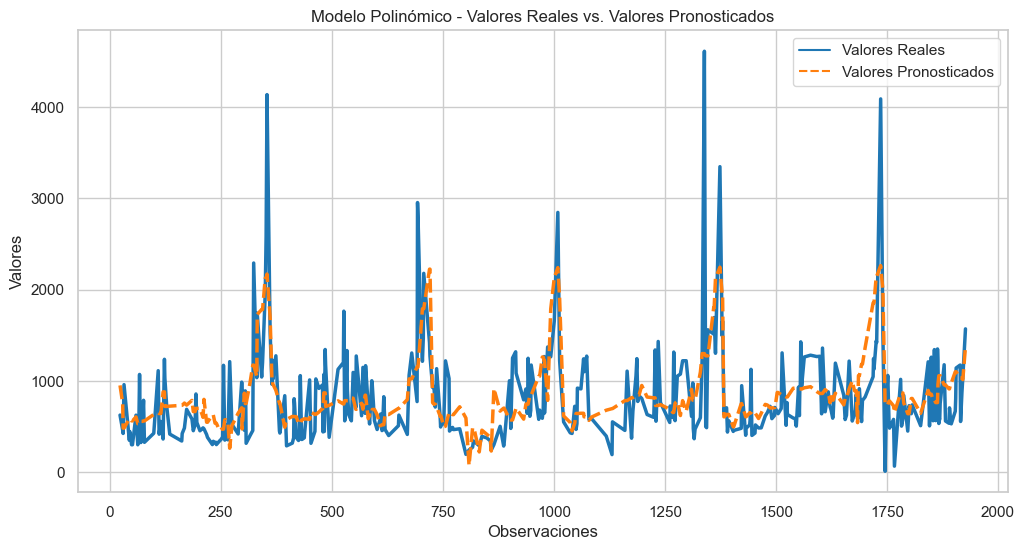

In [11]:
comparison_df = pd.DataFrame({'Valores Reales': y_test, 'Valores Pronosticados': y_pred})
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, palette="tab10", linewidth=2.5)

plt.xlabel("Observaciones")
plt.ylabel("Valores")
plt.title("Modelo Polinómico - Valores Reales vs. Valores Pronosticados")
plt.show()

Revisando la gráfica vemos que el modelo polinómico mejora mucho la lectura de los datos, sobre todo la forma que se ajusta a los meses de temporada alta y navidad. Sin embargo, por alguna razón las ventas de navidad no se pronostican adecuadamente, y ciertos picos de compras pasan desapercibidos por la función de pronóstico. 

## Conclusiones
La regresión lineal y sus variantes es siempre el primer punto de entrada para el análisis por parte de un científico de datos. En nuestro caso particular, sin embargo, aun con la inclusión de regresores que indiquen la presencia de eventos como la navidad en temporada alta, y la pandemia del Covid-19, que impactó negativamente a las ventas, los modelos entrenados no pueden predecir correctamente el comportamiento de las ventas con la data provista. Por lo tanto descartamos este modelo como potable para el uso futuro del análisis de la data histórica para pronosticar temporadas futuras. 